## Example of rigid body dynamic: Pendulum 2D
Given Spatial Velocity $v_0$ and Acceleration $\alpha_0$ of the origin, Moment of Inertia matrix $M$, and forces $f$,find out the Equation of motion of the mass at the *CG* (center of gravity)

In [2]:
using LinearAlgebra

function bracket(omega)
    return [0 -omega[3] omega[2]; omega[3] 0 -omega[1]; -omega[2] omega[1] 0]
end

function RotX(x) 
    Rx = [1 0 0;0 cos(x) -sin(x);0 sin(x) cos(x)]
    return Rx
end

function RotY(y) 
    Ry = [cos(y) 0 sin(y);0 1 0;-sin(y) 0 cos(y)]
    return Ry
end
function RotZ(z) 
    Rz = [cos(z) -sin(z) 0;sin(z) cos(z) 0;0 0 1]
    return Rz
end

function CardanR(x,y,z) #Euler method for rotating around x,y,z axis respectively to get the rotation matrix R
    Rx = [1 0 0;0 cos(x) -sin(x);0 sin(x) cos(x)]
    Ry = [cos(y) 0 sin(y);0 1 0;-sin(y) 0 cos(y)]
    Rz = [cos(z) -sin(z) 0;sin(z) cos(z) 0;0 0 1]
    return Rx*Ry*Rz
end

function Adjoint(twist)
    omega = twist[1:3]
    v = twist[4:6]
    zero = zeros((3,3))
    adj_matrix = [bracket(omega) zero;bracket(v) bracket(omega)]
    return adj_matrix
end

function ad(V)#(small_A small_d for twist V; lecture 15 page 11)
    omega = V[1:3]
    velo = V[4:6]
    zero = zeros((3,3))
    operator = [bracket(omega) zero;bracket(velo) bracket(omega)]    
    return operator
end

function ad_transpose(V) #(small_A small_d for twist V; lecture 15 page 11)
    omega = V[1:3]
    velo = V[4:6]
    zero = zeros((3,3))
    operator = [bracket(omega) bracket(velo);zero bracket(omega)]   
        return operator
    end

function Transfer_Matrix_v(theta,p,ActiveDof) #Adjoint matrix for spatial vectors(big_A small_d)
    zero = zeros((3,3))
    ones = I(3)
    if ActiveDof == "x"
        E = RotX(theta[1])
    elseif ActiveDof == "y"
        E = RotY(theta[2])
    elseif ActiveDof == "z"  
        E = RotZ(theta[3])
    end
    Rotmatrix = [E zero;zero E]
    Transmatrix = [ones zero; -bracket(p) ones]
    D = Transmatrix*Rotmatrix #rotation before translation because we the relative position between o and cg is known
    return D
end

function Transfer_Matrix_f(theta,p,ActiveDof) #adjoint matrix for spatial vectors
        zero = zeros((3,3))
    ones = I(3)
    if ActiveDof == "x"
        E = RotX(theta[1])
    elseif ActiveDof == "y"
        E = RotY(theta[2])
    elseif ActiveDof == "z"  
        E = RotZ(theta[3])
    end
    Rotmatrix = [E zero;zero E]
    Transmatrix = [ones -bracket(p); zero ones]
    D_star  = Transmatrix*Rotmatrix #rotation before translation because we the relative position between o and cg is known
    return D_star
end
function T(ActiveDof)
    T = I(6)
    if ActiveDof == "z"
        T[3,3] = 0  
    end
    return T
end
# function Transformation(M,*S)
#     for s = length(S)
#     exp(bracket(s))
#     end 
#     return 
# end

S (generic function with 1 method)

In [46]:
exp([1 1 1;2 2 2;3 3 3])
Transfer_Matrix_v([1 2 3],[1 2 3],"x")
m=1 #mass of the body = rho*V
MOI=[1 0 0;0 1 0;0 0 1]
Inertia_mat = [MOI zeros(3,3);zeros(3,3) m*I(3)]
inv_inertia_mat = [inv(MOI) zeros(3,3);zeros(3,3) I(3)/m]
ad([1;1;1;1;1;1])
# inv(Inertia_mat)
Force = Transfer_Matrix_f([0;0;pi/2],[0;0;0],"z")*[0;0;0;0;-9.8;0]
Matrixv = Transfer_Matrix_v([0;0;pi/2],[0;-1.5;0],"z")
v_cg = Matrixv*[0;0;0;0;0;0]
inv(Matrixv)*inv_inertia_mat*Force
inv(Matrixv)*[0;0;0;-1;0;0]
inv(Matrixv)*[0;0;pi/2;pi/2*1.5;0;0]
inv(Transfer_Matrix_f([0;0;pi/2],[0;-1.5;0],"z"))*Force
Matrixv*[0;0;pi/2;0;0;0]
Force

6-element Vector{Float64}:
  0.0
  0.0
  0.0
  9.8
 -6.000769315822031e-16
  0.0

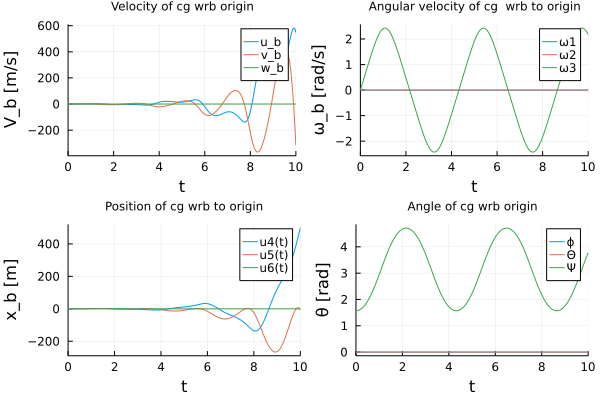

In [4]:
using DifferentialEquations
using LinearAlgebra
using Plots
g = 9.81
M = [2;1.5; 3] # Moment applied on the joint
F = [2.5; 3; 2] # Force applied on the body end
r_O_CG = [0; -1.5; 0]#initial center of mass wrb to joint (inertia frame)
r_end_CG = [0,1.5,0]#initial center of mass wrb to end of body (inertia frame)
m=1 #mass of the body = rho*V
MOI=[5 0 0;0 5 0;0 0 5]
Inertia_mat = [MOI zeros(3,3);zeros(3,3) m*I(3)]
inv_inertia_mat = [inv(MOI) zeros(3,3);zeros(3,3) I(3)/m] #(book equ 2.73)
function EOM3D!(du,u,p,t)
    #u7 = omega1, u8 = omega2, u9 = omega3 , u10 = u, u11 = v, u12 = w; 
#     Force = [0;0;0;0;-m*g;0]
    GravityForce = Transfer_Matrix_f(u[1:3],[0;0;0],"z")*[0;0;0;0;-m*g;0]
    ReactionForce = -T("z")*inv(Transfer_Matrix_f(u[1:3],[0;-1.5;0],"z"))*GravityForce
    Force = GravityForce + Transfer_Matrix_f(u[1:3],[0;-1.5;0],"z")*ReactionForce#position change from [0;0;0] to [0;-1.5;0] 
    Matrixv = Transfer_Matrix_v(u[1:3],u[4:6]+r_O_CG,"z")#cg_D_J
    v_cg = Matrixv*u[7:12]
    du[7:12] = inv(Matrixv)*(inv_inertia_mat*(Force + ad_transpose(v_cg)*Inertia_mat*v_cg))-ad(v_cg)*u[7:12]
    du[1:6] = u[7:12]
end

u0=[0; 0; pi/2; 0; 0; 0; 0; 0; 0; 0; 0; 0]
tspan=(0.0,10)#time span
prob=ODEProblem(EOM3D!,u0,tspan)
sol=solve(prob,reltol=1e-8,Tsit5())

a=plot(sol,vars=(0,[10,11,12]),title="Velocity of cg wrb origin",labels=["u_b" "v_b" "w_b"],ylab = "V_b [m/s]",titlefontsize=8)
b=plot(sol,vars=(0,[7,8,9]),title="Angular velocity of cg  wrb to origin",labels=["ω1" "ω2" "ω3"],ylab = "ω_b [rad/s]",titlefontsize=8)
c=plot(sol,vars=(0,[4,5,6]),title="Position of cg wrb to origin",ylab = "x_b [m]",titlefontsize=8)
d=plot(sol,vars=(0,[1,2,3]),title="Angle of cg wrb origin",labels=["ϕ" "Θ" "Ψ"],ylab = "θ [rad]",titlefontsize=8)
# e=plot(sol,vars=(0,[13,14,15]),title="Position wrb to inertia frame",labels=["x_i" "y_i" "z_i"],ylab = "x_i [m]",titlefontsize=8)
# f=plot(sol,vars=(0,[16,17,18]),title="Velocity wrb to inertia frame",labels=["u_i" "v_i" "w_i"],ylab = "V_i [m/s]",titlefontsize=8)
# plot(a,b,d,f,layout=(2,2))
plot(plot(a,b,layout=(1,2),w=1),plot(c,d,layout=(1,2),w=1),layout=(2,1))